# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import keras
from keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense, GRU, LSTM, Bidirectional
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

#Read File

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving home_equity.csv to home_equity (1).csv
User uploaded file "home_equity.csv" with length 422270 bytes


In [ ]:
df_he = pd.read_csv('home_equity.csv')

In [ ]:
df_he.head()

,HEID,Loan_Amount,Mort_Bal,Home_Val,Reason_HE,Occupation,YOJ,Num_Derog,Num_Delinq,CL_Age,Num_Inq,Num_CL,Debt_Inc,Default
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN,1.0
1,2,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN,1.0
2,3,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN,1.0
3,4,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,5,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN,0.0


In [ ]:
df_he.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5964 entries, 0 to 5963
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HEID         5964 non-null   int64  
 1   Loan_Amount  5964 non-null   int64  
 2   Mort_Bal     5446 non-null   float64
 3   Home_Val     5852 non-null   float64
 4   Reason_HE    5712 non-null   object 
 5   Occupation   5684 non-null   object 
 6   YOJ          5448 non-null   float64
 7   Num_Derog    5254 non-null   float64
 8   Num_Delinq   5382 non-null   float64
 9   CL_Age       5654 non-null   float64
 10  Num_Inq      5453 non-null   float64
 11  Num_CL       5741 non-null   float64
 12  Debt_Inc     4697 non-null   float64
 13  Default      5962 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 652.4+ KB


#Missing Values, Dropping Rows, One Hot Encoding

In [ ]:
df_he.isna().sum()

HEID              0
Loan_Amount       0
Mort_Bal        518
Home_Val        112
Reason_HE       252
Occupation      280
YOJ             516
Num_Derog       710
Num_Delinq      582
CL_Age          310
Num_Inq         511
Num_CL          223
Debt_Inc       1267
Default           2
dtype: int64

In [ ]:
df_he=df_he.dropna()

In [ ]:
len(df_he)

3365

In [ ]:
df_he['Reason_HE'] = df_he['Reason_HE'].map({'HomeImp': 0, 'DebtCon': 1})

In [ ]:
df_he.head()

,HEID,Loan_Amount,Mort_Bal,Home_Val,Reason_HE,Occupation,YOJ,Num_Derog,Num_Delinq,CL_Age,Num_Inq,Num_CL,Debt_Inc,Default
5,6,1700,30548.0,40320.0,0,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,1.0
7,8,1800,28502.0,43034.0,0,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,1.0
19,20,2300,102370.0,120953.0,0,Office,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503,0.0
25,26,2400,34863.0,47471.0,0,Mgr,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601,1.0
26,27,2400,98449.0,117195.0,0,Office,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827,0.0


In [ ]:
# checking features
cat = df_he.select_dtypes(include='O').keys()
# display variabels
cat

Index(['Occupation'], dtype='object')

In [ ]:
# creating new df
# setting columns we use
new_df_he = pd.read_csv('home_equity.csv',usecols=['Occupation']) 
new_df_he.head()

,Occupation
0,Other
1,Other
2,Other
3,NaN
4,Office


In [ ]:
new_df_he.isna().sum()

Occupation    280
dtype: int64

In [ ]:
new_df_he=new_df_he.dropna()

In [ ]:
new_df_he.head()

,Occupation
0,Other
1,Other
2,Other
4,Office
5,Other


In [ ]:
# unique values in each columns
for x in new_df_he.columns:
    #prinfting unique values
    print(x ,':', len(new_df_he[x].unique()))

Occupation : 6


In [ ]:
# finding the top 20 categories
new_df_he.Occupation.value_counts().sort_values(ascending=False).head(6)

Other      2391
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: Occupation, dtype: int64

In [ ]:
# make list with top 6 variables
top_6 = [x for x in new_df_he.Occupation.value_counts().sort_values(ascending=False).head(6).index]
top_6

['Other', 'ProfExe', 'Office', 'Mgr', 'Self', 'Sales']

In [ ]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(new_df_he['Occupation'])
one_hot

,Mgr,Office,Other,ProfExe,Sales,Self
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
4,0,1,0,0,0,0
5,0,0,1,0,0,0
...,...,...,...,...,...,...
5959,0,0,1,0,0,0
5960,0,0,1,0,0,0
5961,0,0,1,0,0,0
5962,0,0,1,0,0,0


In [ ]:
# Drop column B as it is now encoded
df_he = df_he.drop('Occupation',axis = 1)
df_he

,HEID,Loan_Amount,Mort_Bal,Home_Val,Reason_HE,YOJ,Num_Derog,Num_Delinq,CL_Age,Num_Inq,Num_CL,Debt_Inc,Default
5,6,1700,30548.0,40320.0,0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,1.0
7,8,1800,28502.0,43034.0,0,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,1.0
19,20,2300,102370.0,120953.0,0,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503,0.0
25,26,2400,34863.0,47471.0,0,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601,1.0
26,27,2400,98449.0,117195.0,0,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5959,5956,88900,57264.0,90185.0,1,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0.0
5960,5957,89000,54576.0,92937.0,1,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0.0
5961,5958,89200,54045.0,92924.0,1,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0.0
5962,5959,89800,50370.0,91861.0,1,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0.0


In [ ]:
# Join the encoded df
df_he = df_he.join(one_hot)
df_he  

,HEID,Loan_Amount,Mort_Bal,Home_Val,Reason_HE,YOJ,Num_Derog,Num_Delinq,CL_Age,Num_Inq,Num_CL,Debt_Inc,Default,Mgr,Office,Other,ProfExe,Sales,Self
5,6,1700,30548.0,40320.0,0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,1.0,0,0,1,0,0,0
7,8,1800,28502.0,43034.0,0,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,1.0,0,0,1,0,0,0
19,20,2300,102370.0,120953.0,0,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503,0.0,0,1,0,0,0,0
25,26,2400,34863.0,47471.0,0,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601,1.0,1,0,0,0,0,0
26,27,2400,98449.0,117195.0,0,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827,0.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5959,5956,88900,57264.0,90185.0,1,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347,0.0,0,0,1,0,0,0
5960,5957,89000,54576.0,92937.0,1,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971,0.0,0,0,1,0,0,0
5961,5958,89200,54045.0,92924.0,1,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590,0.0,0,0,1,0,0,0
5962,5959,89800,50370.0,91861.0,1,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882,0.0,0,0,1,0,0,0


#Data Imbalance Check

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


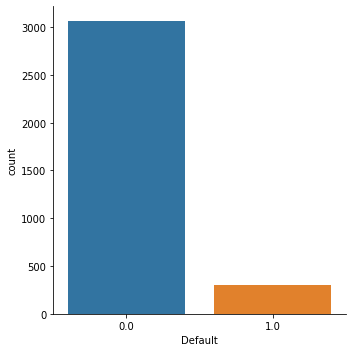

In [ ]:
sns.factorplot(x="Default", 
                    data=df_he, kind="count")

# Correlation 

In [ ]:
#Identifying Redundant Variables
df_he.iloc[:,np.r_[1:16]].corr()

,Loan_Amount,Mort_Bal,Home_Val,Reason_HE,YOJ,Num_Derog,Num_Delinq,CL_Age,Num_Inq,Num_CL,Debt_Inc,Default,Mgr,Office,Other
Loan_Amount,1.000000,0.272916,0.378722,0.177364,0.076368,-0.024258,-0.067460,0.066380,0.051226,0.075863,0.157274,-0.031233,0.044203,-0.065604,-0.070553
Mort_Bal,0.272916,1.000000,0.865259,-0.005490,-0.103373,-0.042609,-0.035929,0.137814,0.036516,0.320789,0.185500,-0.016273,0.061551,-0.070660,-0.253526
Home_Val,0.378722,0.865259,1.000000,-0.038874,-0.021125,-0.045913,-0.068419,0.197567,-0.006857,0.215451,0.130896,-0.026128,0.009729,-0.081201,-0.257281
Reason_HE,0.177364,-0.005490,-0.038874,1.000000,-0.083357,0.004740,-0.023617,-0.065289,0.135222,0.049754,0.018243,0.004773,0.065404,0.009992,0.029385
YOJ,0.076368,-0.103373,-0.021125,-0.083357,1.000000,-0.055733,0.022081,0.229531,-0.046248,-0.001590,-0.052378,-0.065183,0.031779,-0.033450,0.061761
Num_Derog,-0.024258,-0.042609,-0.045913,0.004740,-0.055733,1.000000,0.147847,-0.053874,0.181456,0.065816,0.035054,0.253084,0.025526,-0.032262,0.035951
Num_Delinq,-0.067460,-0.035929,-0.068419,-0.023617,0.022081,0.147847,1.000000,0.011331,0.003393,0.122497,0.038058,0.274146,0.001685,0.030353,0.002453
CL_Age,0.066380,0.137814,0.197567,-0.065289,0.229531,-0.053874,0.011331,1.000000,-0.088091,0.202230,-0.049279,-0.111398,-0.017612,-0.024108,-0.126027
Num_Inq,0.051226,0.036516,-0.006857,0.135222,-0.046248,0.181456,0.003393,-0.088091,1.000000,0.077866,0.157869,0.126694,0.115435,-0.046272,0.042633
Num_CL,0.075863,0.320789,0.215451,0.049754,-0.001590,0.065816,0.122497,0.202230,0.077866,1.000000,0.144015,0.008415,0.006832,0.008704,-0.164395


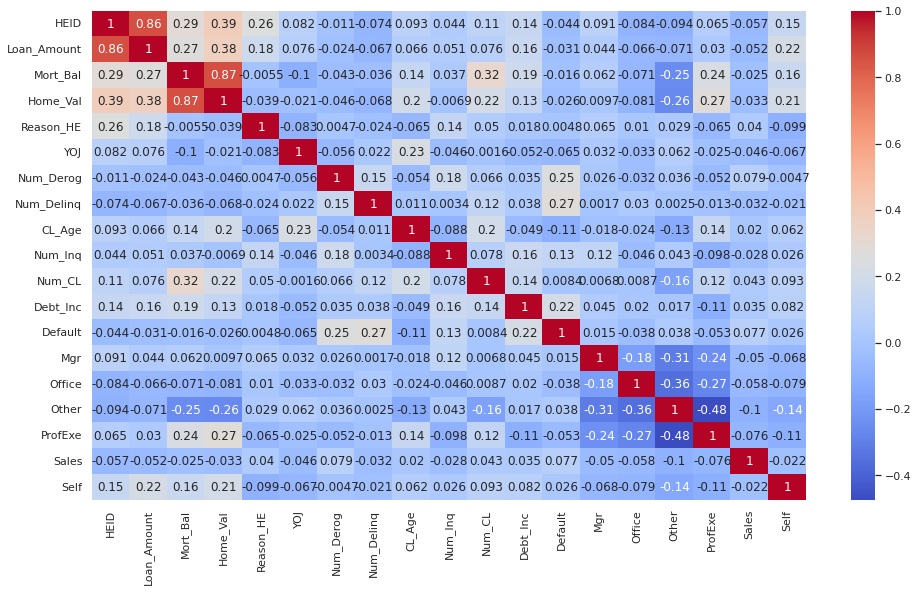

In [ ]:
sns.set(rc = {'figure.figsize':(16,9)})
sns.heatmap(df_he.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

#Training-Testing

In [ ]:
#training/testing data
X = df_he.drop(['Default', 'Num_Derog', 'Num_Delinq'], axis = 1)  
y = df_he.Default 

In [ ]:
#Train-test split 70-30
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 831)

In [ ]:
#Normalizing range 
range_scaler = MinMaxScaler()
range_scaler.fit(x_train)
norm_x_train = range_scaler.transform(x_train)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(x_train, y_train)

#Basic Neural Network Model

In [ ]:
nn_mod = Sequential()

In [ ]:
nn_mod.add(Dense(units = 64,
              activation = 'relu',
              name = 'Hidden_Layer_2'))

In [ ]:
nn_mod.add(Dense(units = 20,
              activation = 'relu',
              name = 'Hidden_Layer_3'))

In [ ]:
nn_mod.add(Dense(units = 10,
              activation = 'relu',
              name = 'Hidden_Layer_4'))

In [ ]:
nn_mod.add(Dense(units = 6,
              activation = 'relu',
              name = 'Hidden_Layer_5'))

In [ ]:
#Dense Output Layer
nn_mod.add(Dense(units = 1,
              activation = 'sigmoid',
              name = 'Output_Layer'))

# Model Evaluation 

In [ ]:
nn_mod.compile(loss = 'binary_crossentropy', 
            optimizer = 'adam',
            metrics = 'accuracy')

In [ ]:
#Model Training
nn_mod_fit = nn_mod.fit(norm_x_train, y_train, batch_size = 32,
          validation_split = 0.1, epochs = 20)

Epoch 1/20
67/67 [==============================] - 1s 6ms/step - loss: 0.3796 - accuracy: 0.9070 - val_loss: 0.3048 - val_accuracy: 0.9153
Epoch 2/20
67/67 [==============================] - 0s 3ms/step - loss: 0.3011 - accuracy: 0.9103 - val_loss: 0.2964 - val_accuracy: 0.9153
Epoch 3/20
67/67 [==============================] - 0s 3ms/step - loss: 0.2964 - accuracy: 0.9103 - val_loss: 0.2962 - val_accuracy: 0.9153
Epoch 4/20
67/67 [==============================] - 0s 3ms/step - loss: 0.2925 - accuracy: 0.9103 - val_loss: 0.2954 - val_accuracy: 0.9153
Epoch 5/20
67/67 [==============================] - 0s 2ms/step - loss: 0.2893 - accuracy: 0.9103 - val_loss: 0.2938 - val_accuracy: 0.9153
Epoch 6/20
67/67 [==============================] - 0s 3ms/step - loss: 0.2876 - accuracy: 0.9103 - val_loss: 0.2962 - val_accuracy: 0.9153
Epoch 7/20
67/67 [==============================] - 0s 3ms/step - loss: 0.2846 - accuracy: 0.9103 - val_loss: 0.2936 - val_accuracy: 0.9153
Epoch 8/20
67/67 [==

In [ ]:
#Model Accuracy
nn_mod.evaluate(norm_x_train, y_train)

74/74 [==============================] - 0s 2ms/step - loss: 0.2410 - accuracy: 0.9257


[0.241017147898674, 0.9256899952888489]

In [ ]:
#Added Hidden Layers
nn_mod.add(Dense(units = 100,
              activation = 'relu',
              name = 'Hidden_Layer_1'))

In [ ]:
#Model History
history_dict = nn_mod_fit.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

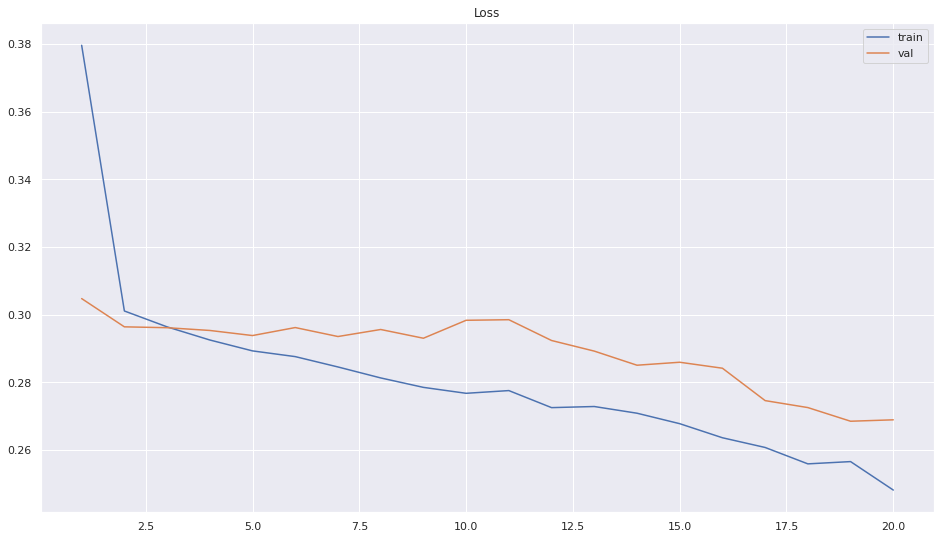

In [ ]:
#Visualized - Epochs
epochs = range(1, len(history_dict['loss']) + 1)
plt.title('Loss')
plt.plot(epochs, history_dict['loss'], label='train')
plt.plot(epochs, history_dict['val_loss'], label='val')
plt.legend()
plt.show();

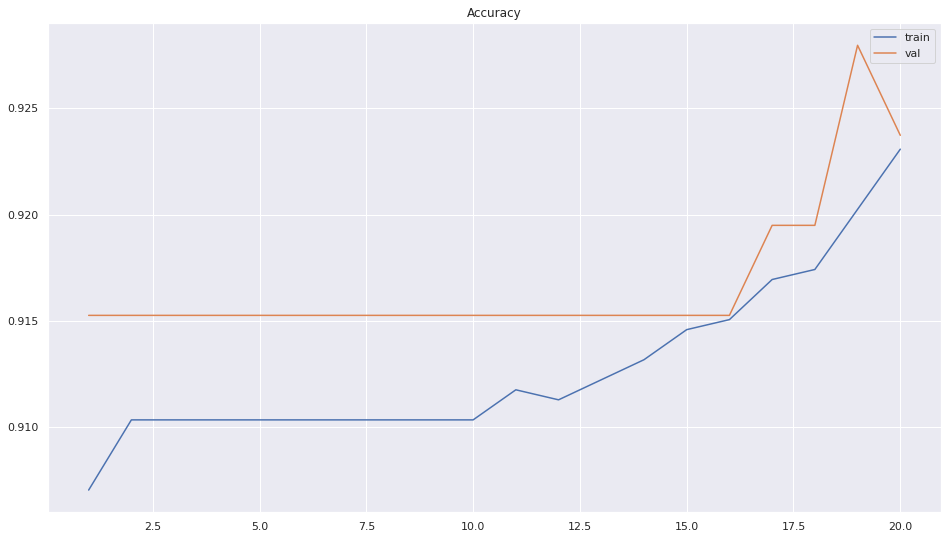

In [ ]:
##Visualized - Accuracy
plt.title('Accuracy')
plt.plot(epochs, history_dict['accuracy'], label='train')
plt.plot(epochs, history_dict['val_accuracy'], label='val')
plt.legend()
plt.show();

#Results

In [ ]:
#Full Training Performance Information
preds_train = (nn_mod.predict(norm_x_train) > 0.5).astype("int32")
print(classification_report(y_train, preds_train, digits=4))

ValueError: ignored

In [ ]:
#Model Prediction and Testing Performance Information
norm_x_test = range_scaler.transform(x_test)

In [ ]:
preds_test = (nn_mod.predict(norm_x_test) > 0.5).astype("int32")
print(classification_report(y_test, preds_test, digits=6))

ValueError: ignored

# Keras Tuner - Hyperparameter Tuning

In [ ]:
pip install -q -U keras-tuner

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  # Tune the number of units in the first Dense layer
  # Choose an optimal value 
  hp_units1 = hp.Int('units_1', min_value = 16, 
                     max_value = 160, 
                     step = 16)
  hp_units2 = hp.Int('units_2', min_value = 16, 
                     max_value = 80, 
                     step = 16)
  hp_units3 = hp.Int('units_3', min_value = 16, 
                     max_value = 32, 
                     step = 8)
  hp_units4 = hp.Int('units_4', min_value = 8, 
                     max_value = 32, 
                     step = 4)
  hp_units5 = hp.Int('units_5', min_value = 8, 
                     max_value = 32, 
                     step = 4)
  model.add(Dense(units = hp_units1, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units2, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units3, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units4, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units5, 
                               activation = 'relu'))
  model.add(Dense(units = 1,
              activation = 'sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.1 - 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4])

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = 'binary_crossentropy',
                metrics = 'accuracy')

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 20,
                     factor = 3,
                     seed = 831,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt3')

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 5)

In [ ]:
tuner.search(norm_x_train, 
             y_train, 
             epochs = 20, 
             batch_size = 32, 
             validation_split = 0.1, 
             callbacks = [stop_early])

In [ ]:
best_mod = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_mod.get_config()

In [ ]:
model_tune = tuner.hypermodel.build(best_mod)
history_tune = model_tune.fit(norm_x_train, 
                              y_train,
                              epochs = best_mod.get('tuner/epochs'),
                              batch_size = 32,
                              validation_split = 0.1)

In [ ]:
preds_train_tune = (model_tune.predict(norm_x_train) > 0.5).astype("int32")
print(classification_report(y_train, preds_train_tune, digits = 6))

In [ ]:
preds_test_tune = (model_tune.predict(norm_x_test) > 0.5).astype("int32")
print(classification_report(y_test, preds_test_tune, digits = 6))